In [20]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install nltk

import numpy as np 
import pandas as pd
from IPython.display import display
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk # for NER
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/test/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/test/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/test/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/test/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/test/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/test/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1-Data Exploration

###### Before preprocessing the dataset, we will explore, prepare, analyze and visualize the datase

In [21]:
# Load the Dataset

colnames = ['sentiment', 'title', 'text']

train_df = pd.read_csv('archive/train.csv', names=colnames)
test_df = pd.read_csv('archive/test.csv' , names=colnames)


In [22]:
# the dataset has been successfully loaded 
print(display(train_df.head()))
print(display(test_df.head()))

,sentiment,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


None


,sentiment,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


None


###### The two dataframes have three columns:

sentiment - Target variable with two categorical levels: 1 if the review is negative (1/2 stars rating); 2 if the review is positive (4/5 stars rating).

title - Heading of the review.

text - Body of the review.

In [23]:
# Inspect the structure of the dataset 

print(train_df.shape)
print(test_df.shape)
print ("\n\n")
print(display(train_df.info()))
print ("\n\n")
print(test_df.info())



(3600000, 3)
(400000, 3)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sentiment  int64 
 1   title      object
 2   text       object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


None

None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  400000 non-null  int64 
 1   title      399976 non-null  object
 2   text       400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB
None


Since the original dataset is huge, for time and memory contsraints we will restrict to a random subset of 50000 rows from train_df and 10000 rows from test_df, which will be respectively our training and validation set. We select such subsets randomly and so that their are both perfectly balanced. We also merge the title and text features in a single text column.

In [24]:
# fill empty titles with empty string
train_df['title'].fillna('', inplace=True)
test_df['title'].fillna('', inplace=True)

# take sample of data for this project
train_len = 50000
test_len = 10000
rs = 42

df = pd.concat([train_df.loc[train_df['sentiment'] == 1].sample(train_len//2, random_state=rs),
                train_df.loc[train_df['sentiment'] == 2].sample(train_len//2, random_state=rs),
                test_df.loc[test_df['sentiment'] == 1].sample(test_len//2, random_state=rs),
                test_df.loc[test_df['sentiment'] == 2].sample(test_len//2, random_state=rs)]).reset_index(drop=True)

# combine title and text
df['text'] = df['title'] + '. ' + df['text']
df.drop('title', axis=1, inplace=True)
df.head() 



,sentiment,text
0,1,The History of Torture and Execution. I have n...
1,1,Stainless Steel shouldn't corrode... should it...
2,1,Another Weak Sequel To A Once Promising Franch...
3,1,"Simply Awful. Contrived, trite, ""Bridget Jones..."
4,1,"FLASH. Jeff Beck's Flash In my opinion, was no..."


In [25]:
print(f'Label counts - training set:\n{df[:train_len].sentiment.value_counts()}')
print(f'\nLabel counts - validation set:\n{df[train_len:].sentiment.value_counts()}')
# checking for missing values
df.isnull().sum() 

Label counts - training set:
sentiment
1    25000
2    25000
Name: count, dtype: int64

Label counts - validation set:
sentiment
1    5000
2    5000
Name: count, dtype: int64


sentiment    0
text         0
dtype: int64

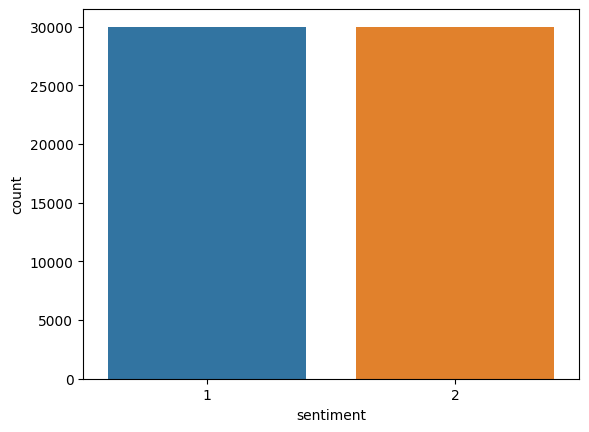

In [26]:
# plot the classes
sns.countplot(x=df["sentiment"]); 

# 2-Text Preprocessing

In [8]:
# function to process text, including Tokenizing, Lemmatizing and Stemmatizinh, Stop Words removals and NER
def preprocess_text(df, text_column, processed_column='text_processed', tokens_column='text_tokens', lemma_column='text_lemmatize', entities_column='text_entities'):
    # Convert text to lowercase and remove punctuation, numbers, and line breaks
    df[processed_column] = df[text_column].str.lower().apply(lambda x: re.sub(r'[^\w\s]|\d|\r|\n', '', x))
    
    # Tokenize the text of processed text
    df[tokens_column] = df[processed_column].apply(lambda x: nltk.word_tokenize(x))
    
    # Remove stop words from tokenized text
    stop_words = set(stopwords.words('english'))
    df[tokens_column] = df[tokens_column].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Remmove suffixes with Lemma and Stemma and find roots
    df[lemma_column] = df[tokens_column].apply(lambda x: [stemmer.stem(lemmatizer.lemmatize(word)) for word in x])
    
    # NER - Extract named entities
    df[entities_column] = df[tokens_column].apply(lambda x: ne_chunk(pos_tag(x)))
    
    
    # Join the tokens back into a single string
#     df['text'] = df['text'].apply(' '.join)
    
    
    return df

In [27]:
df = preprocess_text(df, 'text')

In [28]:
# Let's have a look at our processed Data Frame
df.head()

,sentiment,text,text_processed,text_tokens,text_lemmatize,text_entities
0,1,The History of Torture and Execution. I have n...,the history of torture and execution i have no...,"[history, torture, execution, yet, received, b...","[histori, tortur, execut, yet, receiv, book, o...","[(history, NN), (torture, NN), (execution, NN)..."
1,1,Stainless Steel shouldn't corrode... should it...,stainless steel shouldnt corrode should it we ...,"[stainless, steel, shouldnt, corrode, really, ...","[stainless, steel, shouldnt, corrod, realli, p...","[(stainless, NN), (steel, NN), (shouldnt, NN),..."
2,1,Another Weak Sequel To A Once Promising Franch...,another weak sequel to a once promising franch...,"[another, weak, sequel, promising, franchise, ...","[anoth, weak, sequel, promis, franchis, hellra...","[(another, DT), (weak, JJ), (sequel, NN), (pro..."
3,1,"Simply Awful. Contrived, trite, ""Bridget Jones...",simply awful contrived trite bridget joness di...,"[simply, awful, contrived, trite, bridget, jon...","[simpli, aw, contriv, trite, bridget, jone, di...","[(simply, RB), (awful, JJ), (contrived, VBN), ..."
4,1,"FLASH. Jeff Beck's Flash In my opinion, was no...",flash jeff becks flash in my opinion was not o...,"[flash, jeff, becks, flash, opinion, one, bett...","[flash, jeff, beck, flash, opinion, one, bette...","[(flash, NN), (jeff, NN), (becks, NNS), (flash..."
